<a href="https://colab.research.google.com/github/juansebastianguzmanbuitrago/Clasificaci-n-del-uso-y-la-cobertura-del-suelo-LULC-mediante-aprendizaje-profundo/blob/main/uso_del_suelo_y_cobertura_del_suelo_parte_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Automatización del mapeo de uso y cobertura del suelo con Python
Creadores de contenido: Ankur Mahesh e Isabelle Tingzon

Esta es una continuación de [la Parte 1 del Tutorial de mapeo de uso y cobertura del suelo (LULC)](https://github.com/climatechange-ai-tutorials/lulc-classification/blob/main/land_use_land_cover_part1.ipynb). Anteriormente, aprendió a entrenar un modelo de aprendizaje profundo para clasificar parches de imágenes Sentinel-2 en diferentes categorías de uso y cobertura del suelo.

En este tutorial, aprenderá a:

- descargar sus propias imágenes satelitales Sentinel-2A con Google Earth Engine
- utilizar el modelo entrenado del tutorial anterior para generar automáticamente un mapa LULC para una región de interés

##Índice
1. Introducción a los datos geoespaciales
2. Descargar límites de países
3. Generar imagen satelital Sentinel-2
4. Generar mosaicos GeoJSON de 64 x 64 px
5. Generar mapa LULC
6. Conclusión y próximos pasos
Puede hacer una copia de este tutorial navegando a Archivo->Guardar una copia en Drive.

## Introducción a los datos geoespaciales
Este tutorial ofrece una introducción al procesamiento de datos geoespaciales con Python. Nuestro objetivo es presentar conceptos básicos y herramientas de uso común para manipular, analizar y visualizar datos geoespaciales. Nuestro público objetivo son aquellos que son nuevos en Python como herramienta para el análisis de datos geoespaciales, así como principiantes en el análisis de datos geoespaciales que buscan herramientas para comenzar.
# Tipos de datos espaciales
Las observaciones de datos espaciales se centran en la ubicación. Existen dos tipos principales de datos espaciales:

1. Datos vectoriales: son básicamente puntos, líneas y polígonos. Cada objeto vectorial puede constar de una o más ubicaciones de coordenadas XY. Los vectores se pueden utilizar para representar, por ejemplo, ubicaciones de lugares (p. ej., escuelas, hospitales), carreteras o límites de países. Los objetos vectoriales se pueden almacenar utilizando formatos de datos espaciales como GeoJSON (.geojson), GeoPackage (.gpkg), Shapefile (.shp).
2. Datos ráster: están compuestos por una cuadrícula de píxeles. Algunos ejemplos incluyen imágenes satelitales multiespectrales, mapas de luminosidad nocturna y mapas de elevación digitales. Cada píxel representa un valor o una clase, p. ej., valores de rojo, verde y azul en imágenes satelitales; intensidad de luz nocturna en mapas NTL; altura en mapas de elevación. Los datos ráster se almacenan comúnmente como GeoTIFF (.tiff).
Para obtener más información sobre vectores y ráster, consulte esta referencia.
https://gisgeography.com/spatial-data-types-vector-raster/
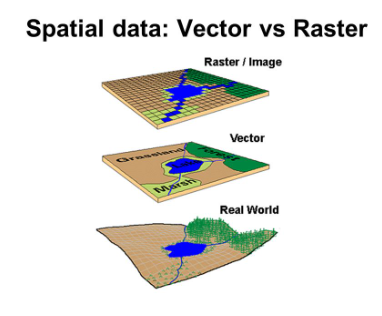

# Sistemas de referencia de coordenadas
Las proyecciones de mapas son representaciones en 2D de la Tierra sobre una superficie plana. Pero como la Tierra es esferoidal, no existe una única forma más precisa de representarla en dos dimensiones, lo que da lugar a una serie de sistemas de coordenadas que sirven para diferentes propósitos (se recomienda ver "Why all world maps are wrong" de Vox: https://www.youtube.com/watch?v=kIID5FDi2JQ&ab_channel=Vox).

Los sistemas de referencia de coordenadas (CRS) proporcionan un método para definir ubicaciones del mundo real en el espacio geográfico. Estos sistemas determinan no solo las ubicaciones de las coordenadas de los objetos, sino también el aspecto del mapa y cómo se calcula la distancia.

Los datos geoespaciales, ya sean vectoriales o raster, siempre van acompañados de información de CRS. Dos sistemas de coordenadas comunes son EPSG:3857 (Web Mercator) y EPSG:4326 (WGS 84); en este tutorial, utilizaremos este último CRS.


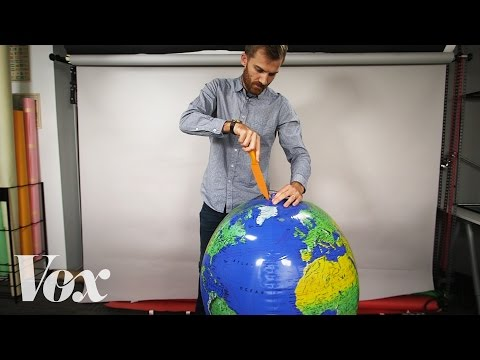

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('kIID5FDi2JQ')

# Herramientas de procesamiento de datos geoespaciales
Presentamos las siguientes herramientas de análisis geoespacial y paquetes de Python:

Google Earth Engine: un archivo de datos público de petabytes de imágenes satelitales históricas y conjuntos de datos geoespaciales. En este tutorial, utilizaremos la API de Python Earth Engine para acceder a las imágenes RGB de Sentinel-2. Tenga en cuenta que deberá registrarse para acceder a Google Earth Engine en https://code.earthengine.google.com/.

GeoPandas: amplía las funcionalidades de pandas para agregar compatibilidad con datos geográficos y análisis geoespacial.https://geopandas.org/en/stable/

Rasterio: los datos ráster, como las imágenes satelitales, a menudo se almacenan utilizando el formato GeoTIFF. Rasterio le permite leer y escribir estos formatos y realizar operaciones geoespaciales avanzadas en estos conjuntos de datos. https://rasterio.readthedocs.io/en/latest/.

Folium: le permite visualizar datos geoespaciales en un mapa de folleto interactivo.https://python-visualization.github.io/folium/.

Para obtener más herramientas de análisis geoespacial, consulte esta lista completa de paquetes de Python.https://github.com/opengeos/python-geospatial
#Importaciones y configuración

In [ ]:
%%capture
!pip -q install --upgrade folium
!apt install libspatialindex-dev
!pip -q install rtree
!pip -q install geopandas
!pip -q install geojson
!pip -q install geemap==0.17.3
!pip -q uninstall tornado -y
!yes | pip install tornado==5.1.0
!pip -q install rasterio
!pip -q install tqdm
!pip -q install eeconvert

In [ ]:
# Standard imports
import os
from tqdm.notebook import tqdm
import requests
import json

import pandas as pd
import numpy as np
from PIL import Image

# Geospatial processing packages
import geopandas as gpd
import geojson

import shapely
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
from shapely.geometry import box

# Mapping and plotting libraries
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import ee
import eeconvert as eec
import geemap
import geemap.eefolium as emap
import folium

# Deep learning libraries
import torch
from torchvision import datasets, models, transforms

# Monte Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Autenticar Google Earth Engine
Asegúrate de haberte registrado para acceder a Google Earth Engine en https://signup.earthengine.google.com/#!/. Una vez que se haya aprobado tu solicitud, deberías poder acceder a Google Earth Engine en https://code.earthengine.google.com/.

In [ ]:
ee.Authenticate()
ee.Initialize(project="<ENTER PROJECT NAME>")

MessageError: Error: credential propagation was unsuccessful

# Descargar límites de país
Nuestro primer paso es descargar los límites administrativos de nuestro país de interés, que obtendremos a través de [geoBoundaries by the William and Mary GeoLab](https://www.geoboundaries.org/index.html). es una base de datos global, gratuita y de acceso abierto, de límites administrativos políticos de todos los países del mundo. Los límites geográficos se pueden descargar a través del acceso API mediante una consulta sencilla:
```
https://www.geoboundaries.org/gbRequest.html?ISO=[3-LETTER-ISO-CODE]&ADM=[ADM-LEVEL]
```
- ISO: El código ISO de tres letras que representa el país de interés. [See this page](https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes)
- ADM: uno de los siguientes: ADM0, ADM1, ADM2, ADM3, ADM4 o ADM5, que representa cada nivel de la jerarquía administrativa.
Para obtener más información, consulte la [API documentation](https://www.geoboundaries.org/api.html).

En este ejemplo, elegimos Alemania como nuestra área de interés. Establecemos el código ISO en "DEU" y ADM en "ADM2". La consulta debe devolver las geometrías de los 403 distritos administrativos de Alemania. En la siguiente celda, enviamos una solicitud para los límites administrativos de Alemania, guardamos el resultado como un archivo GeoJSON y leemos el archivo mediante GeoPandas.

In [ ]:
ISO = 'DEU' # "DEU" is the ISO code for Germany
ADM = 'ADM3' # Equivalent to administrative districts

# Query geoBoundaries
url = f"https://www.geoboundaries.org/api/current/gbOpen/{ISO}/{ADM}"
r = requests.get(url)
download_path = r.json()["gjDownloadURL"]

# Save the result as a GeoJSON
filename = 'geoboundary.geojson'
geoboundary = requests.get(download_path).json()
with open(filename, 'w') as file:
   geojson.dump(geoboundary, file)

# Read data using GeoPandas
geoboundary = gpd.read_file(filename)
print("Data dimensions: {}".format(geoboundary.shape))
geoboundary.sample(3)

KeyboardInterrupt: 

En este ejemplo, visualizamos el límite administrativo del distrito Kreis Borken utilizando la función .plot() de GeoPandas.

In [ ]:
shape_name = 'Borken'
fig, ax = plt.subplots(1, figsize=(10,10))
geoboundary[geoboundary.shapeName == shape_name].plot('shapeName', legend=True, ax=ax);

#Generar imágenes satelitales Sentinel-2
Sentinel-2 es una misión de observación de la Tierra del Programa Copernicus que proporciona imágenes multiespectrales globales cada 10 días (2015 - presente) con una resolución de 10 m (es decir, la longitud de un lado de un píxel es igual a 10 metros).

Las imágenes suelen estar compuestas por 3 canales o bandas: rojo, verde y azul. Sentinel-2, por otro lado, puede capturar 13 bandas espectrales:

- 4 bandas a 10 metros: azul, verde, rojo e infrarrojo cercano
- 6 bandas a 20 metros: para caracterización de la vegetación y para aplicaciones como detección de nieve/hielo/nubes o evaluación del estrés hídrico de la vegetación.
- 3 bandas a 60 metros: principalmente para detección de nubes y correcciones atmosféricas
&nbsp; &nbsp; &nbsp; &nbsp;<img src="https://www.researchgate.net/profile/Gordana_Jovanovska_Kaplan/publication/314119510/figure/tbl1/AS:670480428195846@1536866399263/Sentinel-2-band-characteristics.png" width="400"/>
Para simplificar, en este tutorial solo utilizamos las bandas roja, verde y azul para la clasificación LULC. Sin embargo, los datos multiespectrales contienen información valiosa que puede ser útil para diversas aplicaciones, como la estimación del rendimiento de los cultivos, el monitoreo de la salud de la vegetación, el análisis de la expansión de las áreas edificadas, la detección de asentamientos informales y mucho más. Le recomendamos encarecidamente que explore todo el potencial de las imágenes satelitales Sentinel-2 para aplicaciones relacionadas con el clima.

[Obtenga más información sobre Sentinel-2 aquí](https://www.usgs.gov/centers/eros/science/usgs-eros-archive-sentinel-2?qt-science_center_objects=0#qt-science_center_objects).
## Google Earth Engine
En esta sección, demostraremos cómo usar Google Engine para descargar imágenes satelitales de Sentinel-2. Nuevamente, para simplificar, solo descargaremos las bandas RGB de Sentinel-2: rojo (B4), verde (B3) y azul (B2).

En la siguiente celda, definimos una función para generar una imagen de Sentinel-2 desde Google Earth usando la API de Python Earth Engine. Para minimizar la cobertura de nubes, elegimos agregar una colección de imágenes durante un período de tiempo, en lugar de obtener una sola imagen en una fecha determinada.

In [ ]:
def generate_image(
    region,
    product='COPERNICUS/S2',
    min_date='2018-01-01',
    max_date='2020-01-01',
    range_min=0,
    range_max=2000,
    cloud_pct=10
):

    """Generates cloud-filtered, median-aggregated
    Sentinel-2 image from Google Earth Engine using the
    Pythin Earth Engine API.

    Args:
      region (ee.Geometry): The geometry of the area of interest to filter to.
      product (str): Earth Engine asset ID
        You can find the full list of ImageCollection IDs
        at https://developers.google.com/earth-engine/datasets
      min_date (str): Minimum date to acquire collection of satellite images
      max_date (str): Maximum date to acquire collection of satellite images
      range_min (int): Minimum value for visalization range
      range_max (int): Maximum value for visualization range
      cloud_pct (float): The cloud cover percent to filter by (default 10)

    Returns:
      ee.image.Image: Generated Sentinel-2 image clipped to the region of interest
    """

    # Generate median aggregated composite
    image = ee.ImageCollection(product)\
        .filterBounds(region)\
        .filterDate(str(min_date), str(max_date))\
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", cloud_pct))\
        .median()

    # Get RGB bands
    image = image.visualize(bands=['B4', 'B3', 'B2'], min=range_min, max=range_max)
    # Note that the max value of the RGB bands is set to 65535
    # because the bands of Sentinel-2 are 16-bit integers
    # with a full numerical range of [0, 65535] (max is 2^16 - 1);
    # however, the actual values are much smaller than the max value.
    # Source: https://stackoverflow.com/a/63912278/4777141

    return image.clip(region)

Generamos y visualizamos la imagen satelital Sentinel-2 para el distrito de Borken. La imagen satelital se genera obteniendo la mediana de todas las imágenes Sentinel-2 en 2020 con una cobertura de nubes inferior al 10 %.

In [ ]:
# Get the shape geometry for Kreis Borken
region  = geoboundary.loc[geoboundary.shapeName == shape_name]
centroid = region.iloc[0].geometry.centroid.coords[0]
region = eec.gdfToFc(region) #geodataframe to feature collection

# Generate RGB image using GEE
image = generate_image(
    region,
    product='COPERNICUS/S2', # Sentinel-2A
    min_date='2021-01-01', # Get all images within
    max_date='2021-12-31', # the year 2021
    cloud_pct=10, # Filter out images with cloud cover >= 10.0%
)

# Visualize map
Map = emap.Map(center=[centroid[1], centroid[0]], zoom=10)
Map.addLayer(image, {}, 'Sentinel2')
Map.addLayerControl()
Map

## Exportar imagen a la unidad local
En la siguiente celda, definimos una función para exportar nuestra imagen satelital Sentinel-2 generada a nuestra unidad local de Google Drive.

In [ ]:
def export_image(image, filename, region, folder):
    """Export Image to Google Drive.

    Args:
      image (ee.image.Image): Generated Sentinel-2 image
      filename (str): Name of image, without the file extension
      geometry (ee.geometry.Geometry): The geometry of the area of
        interest to filter to.
      folder (str): The destination folder in your Google Drive.

    Returns:
      ee.batch.Task: A task instance
    """

    print('Exporting to {}.tif ...'.format(filename))

    task = ee.batch.Export.image.toDrive(
      image=image,
      driveFolder=folder,
      scale=10,
      region=region.geometry(),
      description=filename,
      fileFormat='GeoTIFF',
      crs='EPSG:4326',
      maxPixels=900000000
    )
    task.start()

    return task

Ahora podemos proceder a descargar la imagen a nuestro Google Drive local como GeoTIFF.

Nota: ¡Ten cuidado al exportar imágenes grandes, ya que pueden tardar un tiempo en descargarse y podrían consumir espacio de almacenamiento!

In [ ]:
folder = 'Colab Notebooks' # Change this to your file destination folder in Google drive
task = export_image(image, shape_name, region, folder)

Puede ejecutar task.status() repetidamente para supervisar el estado de la tarea. Después de un tiempo, el estado debería cambiar de "LISTO" a "EN EJECUCIÓN" y luego a "COMPLETO".

 Alternativamente, puede ir a https://code.earthengine.google.com/ para verificar el estado de la tarea

In [ ]:
task.status()

## Visualizar imagen Sentinel-2A
Una vez que el estado de la tarea cambie a "COMPLETA", verifique que la imagen satelital se encuentre en su Google Drive. En la siguiente celda, cargamos y visualizamos la imagen satelital rasterizada utilizando la librería Rasterio.

In [ ]:
# Change this to your image file path
cwd = './drive/My Drive/Colab Notebooks/'
tif_file = os.path.join(cwd, '{}.tif'.format(shape_name))

# Uncomment this to download the TIF file
if not os.path.isfile(tif_file):
  tif_file = '{}.tif'.format(shape_name)
  !gdown "12VJQBht4n544OXh4dmugqMESXXxRlBcU"

# Open image file using Rasterio
image = rio.open(tif_file)
boundary = geoboundary[geoboundary.shapeName == shape_name]

# Plot image and corresponding boundary
fig, ax = plt.subplots(figsize=(15,15))
boundary.plot(facecolor="none", edgecolor='red', ax=ax)
show(image, ax=ax);

## Generar mosaicos GeoJSON de 64 x 64 px
Recordemos que en el tutorial anterior, entrenamos un modelo de aprendizaje profundo en el conjunto de datos RGB de EuroSAT, que consta de parches de imágenes Sentinel-2 de 64 x 64 píxeles. Esto significa que también necesitaremos dividir nuestra enorme imagen Sentinel-2 en mosaicos más pequeños de 64 x 64 píxeles.

Comencemos por crear una función que genere una cuadrícula de polígonos cuadrados de 64 x 64 píxeles utilizando las utilidades de la ventana de Rasterio [Rasterio Window utilities](https://rasterio.readthedocs.io/en/latest/api/rasterio.windows.html).

In [ ]:
def generate_tiles(image_file, output_file, area_str, size=64):
    """Generates 64 x 64 polygon tiles.

    Args:
      image_file (str): Image file path (.tif)
      output_file (str): Output file path (.geojson)
      area_str (str): Name of the region
      size(int): Window size

    Returns:
      GeoPandas DataFrame: Contains 64 x 64 polygon tiles
    """

    # Open the raster image using rasterio
    raster = rio.open(image_file)
    width, height = raster.shape

    # Create a dictionary which will contain our 64 x 64 px polygon tiles
    # Later we'll convert this dict into a GeoPandas DataFrame.
    geo_dict = { 'id' : [], 'geometry' : []}
    index = 0

    # Do a sliding window across the raster image
    with tqdm(total=width*height) as pbar:
      for w in range(0, width, size):
          for h in range(0, height, size):
              # Create a Window of your desired size
              window = rio.windows.Window(h, w, size, size)
              # Get the georeferenced window bounds
              bbox = rio.windows.bounds(window, raster.transform)
              # Create a shapely geometry from the bounding box
              bbox = box(*bbox)

              # Create a unique id for each geometry
              uid = '{}-{}'.format(area_str.lower().replace(' ', '_'), index)

              # Update dictionary
              geo_dict['id'].append(uid)
              geo_dict['geometry'].append(bbox)

              index += 1
              pbar.update(size*size)

    # Cast dictionary as a GeoPandas DataFrame
    results = gpd.GeoDataFrame(pd.DataFrame(geo_dict))
    # Set CRS to EPSG:4326
    results.crs = {'init' :'epsg:4326'}
    # Save file as GeoJSON
    results.to_file(output_file, driver="GeoJSON")

    raster.close()
    return results

Ahora podemos crear polígonos cuadrados de tamaño 64x64 px en la imagen satelital Sentinel-2 de Kreis Borken.

In [ ]:
output_file = os.path.join(cwd, '{}.geojson'.format(shape_name))
tiles = generate_tiles(tif_file, output_file, shape_name, size=64)

# Uncomment this to download GeoJSON file
#if not os.path.isfile(output_file):
#  output_file = '{}.geojson'.format(shape_name)
#  !gdown "1h7L17F0SD1xuppWddqAVh64zxH7Cjf9p"

print('Data dimensions: {}'.format(tiles.shape))
tiles.head(3)

## Visualizar mosaicos de 64 x 64 px
Abramos el archivo ráster de Sentinel-2 con Rasterio y superpongamos los polígonos vectoriales de 64 x 64 px de la siguiente manera.

In [ ]:
image = rio.open(tif_file)
fig, ax = plt.subplots(figsize=(15,15))
tiles.plot(facecolor="none", edgecolor='red', ax=ax)
show(image, ax=ax);

Tenga en cuenta que los polígonos también se generan para las regiones vacías (negras). El uso de nuestro modelo para predecir las regiones en blanco parece un desperdicio computacional.

En cambio, podemos obtener la intersección entre:

el polígono del límite del distrito de Borken y
las cuadrículas de 64 x 64.
Para ello, utilizamos la función .sjoin() de GeoPandas. Establecemos el parámetro op='within' para indicar que solo queremos las cuadrículas que se encuentran dentro del límite del distrito.

[Consulte más información sobre la operación sjoin de GeoPandas aquí ](https://geopandas.org/reference/geopandas.sjoin.html).

In [ ]:
image = rio.open(tif_file)

# Geopandas sjoin function
tiles = gpd.sjoin(tiles, boundary, op='within')

fig, ax = plt.subplots(figsize=(15,15))
tiles.plot(facecolor="none", edgecolor='red', ax=ax)
show(image, ax=ax);

## Visualizar una imagen recortada
Ahora podemos recortar nuestra imagen de Sentinel-2 utilizando las cuadrículas generadas.

Aquí, visualizamos la imagen de Sentinel-2 recortada utilizando el primer mosaico.

In [ ]:
def show_crop(image, shape, title=''):
  """Crops an image based on the polygon shape.
  Reference: https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html#rasterio.mask.mask

  Args:
    image (str): Image file path (.tif)
    shape (geometry): The tile with which to crop the image
    title(str): Image title
  """

  with rio.open(image) as src:
      out_image, out_transform = rio.mask.mask(src, shape, crop=True)
      # Crop out black (zero) border
      _, x_nonzero, y_nonzero = np.nonzero(out_image)
      out_image = out_image[
        :,
        np.min(x_nonzero):np.max(x_nonzero),
        np.min(y_nonzero):np.max(y_nonzero)
      ]
      # Visualize image
      show(out_image, title=title)

show_crop(tif_file, [tiles.iloc[5]['geometry']])

## Generar un mapa de uso y cobertura del suelo
En esta sección, generaremos nuestro mapa de clasificación de uso y cobertura del suelo utilizando el modelo entrenado en el tutorial anterior. Recuerde que el conjunto de datos de EuroSAT consta de 10 clases LULC diferentes, como se detalla a continuación.

In [ ]:
# LULC Classes
classes = [
  'AnnualCrop',
  'Forest',
  'HerbaceousVegetation',
  'Highway',
  'Industrial',
  'Pasture',
  'PermanentCrop',
  'Residential',
  'River',
  'SeaLake'
]

## Cargar el modelo entrenado en EuroSAT
Primero, carga el modelo entrenado. En caso de que te hayas perdido la Parte 1 del tutorial, también puedes descomentar el código a continuación para descargar el modelo entrenado directamente.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_file = cwd+'/models/best_model.pth'

# Uncomment this to download the model file
if not os.path.isfile(model_file):
  model_file = 'best_model.pth'
  !gdown "13AFOESwxKmexCoOeAbPSX_wr-hGOb9YY"

model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model.load_state_dict(torch.load(model_file, map_location=device))
model.eval()

print('Model file {} successfully loaded.'.format(model_file))

Recuerde que en el tutorial anterior aplicamos un conjunto de transformaciones de datos a nuestro conjunto de prueba. Antes de ejecutar nuestras nuevas imágenes a través del modelo, necesitaremos aplicar estas mismas transformaciones a nuestros nuevos datos de la siguiente manera.

In [ ]:
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

## Predicción de modelos y generación de mapas LULC
A continuación, definamos una función que:
1. Recorta la imagen de origen utilizando la geometría de mosaico de 64 x 64
2. Genera una predicción para la imagen recortada utilizando el modelo entrenado

In [ ]:
def predict_crop(image, shape, classes, model, show=False):
    """Generates model prediction using trained model

    Args:
      image (str): Image file path (.tiff)
      shape (geometry): The tile with which to crop the image
      classes (list): List of LULC classes

    Return
      str: Predicted label
    """

    with rio.open(image) as src:
        # Crop source image using polygon shape
        # See more information here:
        # https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html#rasterio.mask.mask
        out_image, out_transform = rio.mask.mask(src, shape, crop=True)
        # Crop out black (zero) border
        _, x_nonzero, y_nonzero = np.nonzero(out_image)
        out_image = out_image[
          :,
          np.min(x_nonzero):np.max(x_nonzero),
          np.min(y_nonzero):np.max(y_nonzero)
        ]

        # Get the metadata of the source image and update it
        # with the width, height, and transform of the cropped image
        out_meta = src.meta
        out_meta.update({
              "driver": "GTiff",
              "height": out_image.shape[1],
              "width": out_image.shape[2],
              "transform": out_transform
        })

        # Save the cropped image as a temporary TIFF file.
        temp_tif = 'temp.tif'
        with rio.open(temp_tif, "w", **out_meta) as dest:
          dest.write(out_image)

        # Open the cropped image and generated prediction
        # using the trained Pytorch model
        image = Image.open(temp_tif)
        input = transform(image)
        output = model(input.unsqueeze(0))
        _, pred = torch.max(output, 1)
        label = str(classes[int(pred[0])])

        if show:
          out_image.show(title=label)

        return label

    return None

Repasemos cada mosaico de 64 x 64 píxeles y generemos predicciones de modelos para la imagen recortada correspondiente. Tenga en cuenta que estamos sobrescribiendo cada archivo TIFF temporal para ahorrar espacio de almacenamiento.

In [ ]:
# Commence model prediction
labels = [] # Store predictions
for index in tqdm(range(len(tiles)), total=len(tiles)):
  label = predict_crop(tif_file, [tiles.iloc[index]['geometry']], classes, model)
  labels.append(label)
tiles['pred'] = labels

# Save predictions
filepath = os.path.join(cwd, "{}_preds.geojson".format(shape_name))
tiles.to_file(filepath, driver="GeoJSON")

tiles.head(3)

## Visualizar un mapa LULC interactivo
Por último, le mostramos cómo generar un mapa LULC interactivo utilizando Folium. Comencemos cargando las predicciones resultantes.

In [ ]:
filepath = os.path.join(cwd, "{}_preds.geojson".format(shape_name))

# Uncomment this to download the model predictions
if not os.path.isfile(filepath):
  filepath = "{}_preds.geojson".format(shape_name)
  !gdown "1LN4efjd3WPGB1TtNiaHcRbFyBzbFY52A"

tiles = gpd.read_file(filepath)
tiles.head(3)

Luego asignamos cada etiqueta a un color correspondiente.

In [ ]:
# We map each class to a corresponding color
colors = {
  'AnnualCrop' : 'lightgreen',
  'Forest' : 'forestgreen',
  'HerbaceousVegetation' : 'yellowgreen',
  'Highway' : 'gray',
  'Industrial' : 'red',
  'Pasture' : 'mediumseagreen',
  'PermanentCrop' : 'chartreuse',
  'Residential' : 'magenta',
  'River' : 'dodgerblue',
  'SeaLake' : 'blue'
}
tiles['color'] = tiles["pred"].apply(
  lambda x: cl.to_hex(colors.get(x))
)
tiles.head(2)

Tenga en cuenta que puede activar o desactivar el mapa utilizando los controles de la parte superior derecha.

In [ ]:
# Instantiate map centered on the centroid
map = folium.Map(location=[centroid[1], centroid[0]], zoom_start=10)

# Add Google Satellite basemap
folium.TileLayer(
      tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
      attr = 'Google',
      name = 'Google Satellite',
      overlay = True,
      control = True
).add_to(map)

# Add LULC Map with legend
legend_txt = '<span style="color: {col};">{txt}</span>'
for label, color in colors.items():

  # Specify the legend color
  name = legend_txt.format(txt=label, col=color)
  feat_group = folium.FeatureGroup(name=name)

  # Add GeoJSON to feature group
  subtiles = tiles[tiles.pred==label]
  if len(subtiles) > 0:
    folium.GeoJson(
        subtiles,
        style_function=lambda feature: {
          'fillColor': feature['properties']['color'],
          'color': 'black',
          'weight': 1,
          'fillOpacity': 0.5,
        },
        name='LULC Map'
    ).add_to(feat_group)
    map.add_child(feat_group)

folium.LayerControl().add_to(map)
map

## Conclusión
¡Felicitaciones por haber llegado hasta el final! Para resumir, en este tutorial aprendiste a descargar una imagen satelital Sentinel-2 para una región de interés usando Google Earth Engine y a aplicar un modelo CNN entrenado para generar un mapa de uso y cobertura del suelo. Como ejercicio, intenta aplicar el modelo a otra región, por ejemplo, tu país de origen. ¿Qué tan bien funciona el modelo en esta nueva geografía?

## Limitaciones de los datos
Si ha intentado aplicar el modelo a otra región del mundo, encontrará que el modelo no funciona tan bien en determinadas áreas. A continuación, se indican algunas de las limitaciones del conjunto de datos EuroSAT:

- Categorías de escenas limitadas. Las 10 clases de cobertura terrestre del conjunto de datos EuroSAT no son representativas del contenido complejo de los datos de teledetección. Estas etiquetas de clase no están mutuamente disjuntas (por ejemplo, una imagen puede contener tanto una autopista como una zona residencial) y su unión no cubre la distribución en el mundo real (por ejemplo, ciertos tipos de cobertura terrestre, como las tierras desérticas y la acuicultura, no están presentes en el conjunto de datos).
- Transferencia limitada del modelo. Al igual que muchos conjuntos de datos de teledetección existentes, EuroSAT, que consta de imágenes satelitales distribuidas por toda Europa, sufre de una cobertura geográfica limitada que restringe la generalización del modelo a otras regiones del mundo. Por lo tanto, es necesaria la colaboración con diversas instituciones de investigación y mayores esfuerzos de intercambio de datos para mejorar la cobertura global de los conjuntos de datos de teledetección anotados.

## Aplicaciones relacionadas con el clima
- Detección de cambios en el uso y la cobertura del suelo. Dado que Sentinel-2 seguirá recopilando datos de RS durante las próximas décadas, un próximo paso prometedor es utilizar el modelo entrenado para observar y detectar cambios en la cobertura del suelo.[MapBiomas](https://plataforma.brasil.mapbiomas.org/), por ejemplo, es una plataforma que visualiza los cambios LULC en Brasil durante un largo período de tiempo. Esto puede ser particularmente útil para la planificación urbana, el monitoreo ambiental y la protección de la naturaleza. La deforestación, por ejemplo, contribuye significativamente al cambio climático; monitorear los cambios en la cobertura forestal e identificar los impulsores de la pérdida forestal puede ser útil para los esfuerzos de conservación y restauración forestal.
- Análisis de las emisiones de carbono del cambio de uso del suelo. Analizar la conversión de la categoría de uso del suelo junto con los cambios en el almacenamiento de carbono del suelo puede ayudar a cuantificar la contribución del cambio de uso del suelo y la gestión del suelo a las emisiones totales de carbono, como se demuestra en este estudio de [2016 study by Lai et al](https://advances.sciencemag.org/content/2/11/e1601063). El estudio encontró que el cambio de uso del suelo, en particular la urbanización, que ha llevado a una rápida expansión de las áreas construidas y una pérdida masiva del almacenamiento de carbono terrestre, ha resultado en grandes emisiones de carbono en China. Esto puede socavar significativamente los objetivos de reducción de emisiones de carbono a menos que se tomen medidas adecuadas para controlar la urbanización y mejorar la gestión de la tierra.
- Evaluación de la vulnerabilidad de diferentes tipos de cobertura terrestre. La superposición de mapas de cobertura terrestre con varios mapas de peligros geoespaciales (por ejemplo, trayectorias de huracanes, fallas sísmicas y mapas de inundaciones) y mapas de proyección climática puede ser útil para evaluar la vulnerabilidad de ciertos tipos de cobertura terrestre, como asentamientos y tierras agrícolas, a diferentes riesgos. Cuando se comparten con organizaciones humanitarias y agencias gubernamentales, estos mapas tienen el potencial de respaldar la planificación de la reducción del riesgo de desastres, así como los esfuerzos de mitigación y adaptación climática a largo plazo.

## Otros conjuntos de datos de teledetección
- So2Sat LCZ42: un conjunto de datos de referencia para la clasificación de zonas climáticas locales globales ([datos](https://mediatum.ub.tum.de/1483140), [artículo](https://arxiv.org/pdf/1912.12171.pdf))
- RESISC45: conjunto de datos de clasificación de escenas de teledetección de alta resolución ([datos](https://www.tensorflow.org/datasets/catalog/resisc45), [artículo](https://arxiv.org/abs/1703.00121))
- BigEarthNet: referencia Sentinel-2 a gran escala ([datos](http://bigearth.net/), [artículo](https://arxiv.org/abs/1902.06148))

[Consulte este repositorio de Github](https://github.com/chrieke/awesome-satellite-imagery-datasets) para obtener una colección más completa de conjuntos de datos de imágenes satelitales.
##Próximos pasos
¿Le interesa aprender más sobre el cambio climático y el aprendizaje automático?

Le recomendamos que consulte nuestro artículo, que ofrece una guía detallada sobre las formas en que se puede utilizar el aprendizaje automático para abordar el cambio climático. No dude en consultar nuestra wiki y los tutoriales en nuestro sitio web. También le recomendamos que se una a las conversaciones en nuestro foro de debate, que envíe sus ideas a nuestros talleres, que asista a nuestros eventos y talleres y, por supuesto, que se suscriba a nuestro boletín informativo.

##Comentarios
¿Tiene algún comentario/sugerencia/comentario? ¿Le interesa colaborar? Póngase en contacto con nosotros en: ankur.mahesh@berkeley.edu issatingzon@climatechange.ai milojevic dupont@gmail.com

## Referencias
Sistemas de referencia de coordenadas: introducción a los conceptos geoespaciales. (sin fecha). Data Carpentry: introducción a los conceptos geoespaciales. Recuperado el 14 de febrero de 2021 de https://datacarpentry.org/organization-geospatial/03-crs/
Archivo EROS del USGS: Sentinel-2. (sin fecha). USGS. Recuperado el 14 de febrero de 2021 de https://www.usgs.gov/centers/eros/science/usgs-eros-archive-sentinel-2?qt-science_center_objects=0#qt-science_center_objects
Long, Yang, Gui-Song Xia, Shengyang Li, Wen Yang, Michael Ying Yang, Xiao Xiang Zhu, Liangpei Zhang y Deren Li. “DIRS: sobre la creación de conjuntos de datos de referencia para la interpretación de imágenes de teledetección”. Preimpresión de arXiv arXiv:2006.12485 (2020). https://arxiv.org/pdf/1912.12171.pdf
Zhu, Xiao Xiang, et al. “So2Sat LCZ42: Un conjunto de datos de referencia para la clasificación global de zonas climáticas locales”. Preimpresión de arXiv arXiv:1912.12171 (2019). https://arxiv.org/pdf/1912.12171.pdf
Sumbul, Gencer, et al. "Bigearthnet: Un archivo de referencia a gran escala para la comprensión de imágenes de teledetección". IGARSS 2019-2019 IEEE International Geoscience and Remote Sensing Symposium. IEEE, 2019.
Lai, Li, et al. "Emisiones de carbono derivadas del cambio y la gestión del uso de la tierra en China entre 1990 y 2010". Avances científicos 2.11 (2016): e1601063.